<a href="https://colab.research.google.com/github/JpChii/nlp-with-hugging-face/blob/main/notebooks/9-dealing-with-few-to-no-labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install -r requirements.txt

# Dealing with Few to No Labels

At the start of every project, the first question any data scientist asks? Is there any labelled data? Answer's mostly no or little bit. And on top of client's expectation that our fancy machine learning models should still perform well. One obvious apporach is annotate more data, but this is more expensive if each annotation has to be validated by a domain expert.

Fortunaley there are several methods that are suited for dealing with few to no labels. Like *Zero-shot* in GPT-3 where it perfoms over a diverse range of tasks with a few dozen examples.

In general, the best-performing method will depend upon task, data, how much of the data is labeled.

*The below picture will guide us through the process of picking the most appropriate method*
![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/9-dealing-with-few-to-no-labels/technqiques-to-deal-with-less-to-no-labelled-data.png?raw=1)

Let's walk through this decision tree:

1. Is labeld data available?

Evan a handful of labeled of labeled samples can make a difference with regards to which method works best. If no labeld data is available then we can start with zero-shot learning which often sets a strong baseline to work from.

2. How many labels?

If we lots of labelled training data available then we can use the fine tuning approach used in [notebook 2](../notebooks/2-text-classification.ipynb)

3. Is there unlabeled data available?

If we have a handful of labeled samples it can help immensley if we have access to large amounts ot unlabeled data. If we have access to unlabeled data, we can use it to fine-tune the language model on the domain before training the classifier, or use more sophisticated methods like unsupervised data augmentation(UDA) or uncertainy-aware self-training(UST). If no unlabeled data is available, we can't annotate more data. In this case we can use few-shot learning or use the embeddings from a pretrained language model to perform lookups with a nearest neighbor search.

Int this notebook, we'll work our way through the decision tree by tackling a common problem facing many support teams that use issue trackers like Jira or Github to assist their users: tagging issues with metadata based on the issue's description. These tags define issue type,product causing the issue, responsible team. Automating the process will have an big impact on productivity and enables the support teams to focus on helping the users. In this notebook, we'll use issues associated with a populat open source project: Transformers. Let's now take a look at what information is available in these issues, what is the task and how to get the data.

> **Note:** The methods used in this notebooks will work well for text classification, but other techniques such as data augmentation may be necessary for dealing with more complex tasks like named entity recognition, question answering or summarization.

## Building a Github Issues Tagger

If we navgate to [issues tab](https://github.com/huggingface/transformers/issues) of transformers, we'll have each issues with title, description, set of tags or labels to chracterize the issue. The supervised learning task: given a title, description of an issue, predict one or more labels, this means we are dealing with multlable classification problem.

*Single issue*
![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/9-dealing-with-few-to-no-labels/singe-issue.png?raw=1)

Now we've seen how the Github Issues look like, next let's see how to download and create our dataset.

To grab all repository's issues, we'll use the [GitHub REST API](https://docs.github.com/en/rest?apiVersion=2022-11-28) to poll the [Issues endpoint](https://docs.github.com/en/rest/issues#list-repository-issues). This endpoint returns a list of json objects, with each object contatining, issue, title, description, whether issue is open or close, owho opend it etc.

Since it takes a while to fetch all issues, we'll use the *github-issues-transformers-json* file. Along with `fetch_issues()` function to download them.

> **Note:** The GitHub REST API treats pull requests as issues, so our dataset contains both issues and pull requests. To keep things simple. we'' develop our classifier for both issue types, althoug in practice we can have two seperated classifiers to have more fine-grained control over the model's performance.

In [9]:
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(
    owner="huggingface",
    repo="transformers",
    num_issues=10_000,
    rate_limit=5_000,
):
    batch = []
    all_issues = []
    per_page = 100 # Number of issues to return per page
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"

    for page in tqdm(range(num_pages)):
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues)

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = [] # Flush batch for next time period
            print(f"Reached Github rate limit. Sleeping for one hour...")
            time.sleep(60 * 60 + 1)
    all_issues.extend(batch)
    df = pd.DataFrrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

This function will download all the issues in batches to avoid exceeding GitHub's limit on number of requests per hour. Let's download the file.

### Preparing the data

In [10]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [11]:
df_issues

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,milestone,comments,created_at,updated_at,closed_at,author_association,active_lock_reason,body,performed_via_github_app,pull_request
0,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849568459,MDU6SXNzdWU4NDk1Njg0NTk=,11046,Potential incorrect application of layer norm ...,...,NaN,0,2021-04-03 03:37:32,2021-04-03 03:37:32,NaT,NONE,None,"In BlenderbotSmallDecoder, layer norm is appl...",NaN,None
1,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849544374,MDU6SXNzdWU4NDk1NDQzNzQ=,11045,Multi-GPU seq2seq example evaluation significa...,...,NaN,0,2021-04-03 00:52:24,2021-04-03 00:52:24,NaT,NONE,None,\r\n### Who can help\r\n@patil-suraj @sgugger ...,NaN,None
2,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849529761,MDU6SXNzdWU4NDk1Mjk3NjE=,11044,[DeepSpeed] ZeRO stage 3 integration: getting ...,...,NaN,0,2021-04-02 23:40:42,2021-04-03 00:00:18,NaT,COLLABORATOR,None,"**[This is not yet alive, preparing for the re...",NaN,None
3,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849499734,MDU6SXNzdWU4NDk0OTk3MzQ=,11043,Can't load model to estimater,...,NaN,0,2021-04-02 21:51:44,2021-04-02 21:51:44,NaT,NONE,None,I was trying to follow the Sagemaker instructi...,NaN,None
4,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849274362,MDU6SXNzdWU4NDkyNzQzNjI=,11042,[LXMERT] Unclear what img_tensorize does with ...,...,NaN,0,2021-04-02 15:12:57,2021-04-02 15:15:07,NaT,NONE,None,## Environment info\r\n\r\n- `transformers` ve...,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9925,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/pu...,486208136,MDExOlB1bGxSZXF1ZXN0MzExNzA2NjQ5,1127,DistilBERT,...,NaN,2,2019-08-28 07:34:11,2020-01-09 13:36:31,2019-08-28 14:43:10,MEMBER,None,"Preparing the release for DistilBERT (smaller,...",NaN,{'url': 'https://api.github.com/repos/huggingf...
9926,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,486120054,MDU6SXNzdWU0ODYxMjAwNTQ=,1126,Bert initialization,...,NaN,2,2019-08-28 02:01:59,2019-09-02 06:53:22,2019-09-02 06:53:22,NONE,None,"When I train bert model from scratch, it can n...",NaN,None
9927,https://api.github.com/repos/huggingface/trans...,http

In [12]:
df_issues.iloc[0]

url                         https://api.github.com/repos/huggingface/trans...
repository_url              https://api.github.com/repos/huggingface/trans...
labels_url                  https://api.github.com/repos/huggingface/trans...
comments_url                https://api.github.com/repos/huggingface/trans...
events_url                  https://api.github.com/repos/huggingface/trans...
html_url                    https://github.com/huggingface/transformers/is...
id                                                                  849568459
node_id                                              MDU6SXNzdWU4NDk1Njg0NTk=
number                                                                  11046
title                       Potential incorrect application of layer norm ...
user                        {'login': 'sougata-ub', 'id': 59206549, 'node_...
labels                                                                     []
state                                                           

There are almost 10,000 issues in our dataset, and by looking at df info, we've URLs, IDs, dates, users, title, body as well as labels

In [13]:
# cols needed
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [14]:
df_issues.loc[2, "labels"]

[{'id': 2659267025,
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed',
  'name': 'DeepSpeed',
  'color': '4D34F7',
  'default': False,
  'description': ''}]

The `labels` column is the thing we're interested in, and each row contain a list of JSON objects with metadata about each label.
For our purpose we need only `name` field of each object, let's overwrite the `labels` columns with just the label names:

In [15]:
df_issues["labels"].apply(
    lambda x: [meta["name"] for meta in x]
)[:20]

0              []
1              []
2     [DeepSpeed]
3              []
4              []
5              []
6              []
7              []
8              []
9              []
10             []
11             []
12             []
13             []
14             []
15             []
16             []
17             []
18             []
19             []
Name: labels, dtype: object

In [16]:
df_issues["labels"] = df_issues["labels"].apply(
    lambda x: [meta["name"] for meta in x]
)
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


Now each row in `labels` column is a list of GitHub labels, next let's compute the length of labels to find out out number of labels per issue.

<Axes: >

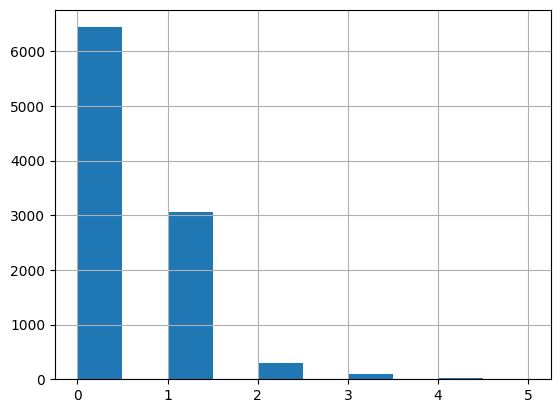

In [17]:
df_issues["labels"].apply(
    lambda x: len(x)
).hist()

More than 60% data has no labels.

In [18]:
df_issues["labels"].apply(
    lambda x: len(x)
).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


In [19]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
df_counts.to_frame().head(8).T

Number of labels: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


In [20]:
df_issues["labels"].explode()

0             NaN
1             NaN
2       DeepSpeed
3             NaN
4             NaN
          ...    
9925          NaN
9926          NaN
9927          NaN
9928          NaN
9929      wontfix
Name: labels, Length: 10522, dtype: object

We can see that there are 65 unique labels in the dataset and the classes are very imbalanced with `wontfix` and `modelcard` being the most common labels. To make the classification problem more traceable, we'll build a tagger on subset of labels that are potentially difficult fo find like `First Issue` and `Help Wanted`, for `model card` a simple rule that detects whena a model card is added on the Hugging Face Hub.

The following code filters the dataset for the subset of labels and simplifies the labels for ease of use.

In [21]:
label_map = {
    "Core: Tokenization": "tokenization",
    "New model": "new model",
    "Core: Modeling": "model training",
    "Usage": "usage",
    "Core: Pipeline": "pipeline",
    "TensorFlow": "tensorflow or tf",
    "PyTorch": "pytorch",
    "Examples": "examples",
    "Documentation": "documentation"
}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [22]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels after label map: {len(df_counts)}")
df_counts.to_frame().T

Number of labels after label map: 9


,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


Let's create a new column to identify whether the issue is labelled or not, which'll be useful later.

In [23]:
df_issues["split"] = "unlabeled"
df_issues.head()

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,comments,created_at,updated_at,closed_at,author_association,active_lock_reason,body,performed_via_github_app,pull_request,split
0,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849568459,MDU6SXNzdWU4NDk1Njg0NTk=,11046,Potential incorrect application of layer norm ...,...,0,2021-04-03 03:37:32,2021-04-03 03:37:32,NaT,NONE,None,"In BlenderbotSmallDecoder, layer norm is appl...",NaN,None,unlabeled
1,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849544374,MDU6SXNzdWU4NDk1NDQzNzQ=,11045,Multi-GPU seq2seq example evaluation significa...,...,0,2021-04-03 00:52:24,2021-04-03 00:52:24,NaT,NONE,None,\r\n### Who can help\r\n@patil-suraj @sgugger ...,NaN,None,unlabeled
2,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849529761,MDU6SXNzdWU4NDk1Mjk3NjE=,11044,[DeepSpeed] ZeRO stage 3 integration: getting ...,...,0,2021-04-02 23:40:42,2021-04-03 00:00:18,NaT,COLLABORATOR,None,"**[This is not yet alive, preparing for the re...",NaN,None,unlabeled
3,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849499734,MDU6SXNzdWU4NDk0OTk3MzQ=,11043,Can't load model to estimater,...,0,2021-04-02 21:51:44,2021-04-02 21:51:44,NaT,NONE,None,I was trying to follow the Sagemaker instructi...,NaN,None,unlabeled
4,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849274362,MDU6SXNzdWU4NDkyNzQzNjI=,11042,[LXMERT] Unclear what img_tensorize does with ...,...,0,2021-04-02 15:12:57,2021-04-02 15:15:07,NaT,NONE,None,## Environment info\r\n\r\n- `transformers` ve...,NaN,None,unlabeled


In [24]:
df_issues["labels"].apply(lambda x: len(x)) > 0

0       False
1       False
2       False
3       False
4       False
        ...  
9925    False
9926    False
9927    False
9928    False
9929    False
Name: labels, Length: 9930, dtype: bool

In [25]:
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [26]:
# Let's check a single sample
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In this example, a new model architecture is proposed, so the label `new model` makes sense. title also has some useful information, let's concatenate title with body field:

In [27]:
df_issues["text"] = df_issues.apply(
    lambda x: x["title"] + "\n\n" + x["body"], axis=1
)

In [28]:
df_issues[["text", "title", "body"]].head()

,text,title,body
0,Potential incorrect application of layer norm ...,Potential incorrect application of layer norm ...,"In BlenderbotSmallDecoder, layer norm is appl..."
1,Multi-GPU seq2seq example evaluation significa...,Multi-GPU seq2seq example evaluation significa...,\r\n### Who can help\r\n@patil-suraj @sgugger ...
2,[DeepSpeed] ZeRO stage 3 integration: getting ...,[DeepSpeed] ZeRO stage 3 integration: getting ...,"**[This is not yet alive, preparing for the re..."
3,Can't load model to estimater\n\nI was trying ...,Can't load model to estimater,I was trying to follow the Sagemaker instructi...
4,[LXMERT] Unclear what img_tensorize does with ...,[LXMERT] Unclear what img_tensorize does with ...,## Environment info\r\n\r\n- `transformers` ve...


Before looking at rest of the data, let's remove the duplicates.

In [29]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before - len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


We've removed few duplicate issues in our dataset, but that's only a small percentage. Next let's take a look at the distribution of words to see if we'll loose much information when we truncate to each model's context size:

Text(0, 0.5, 'Number of issues')

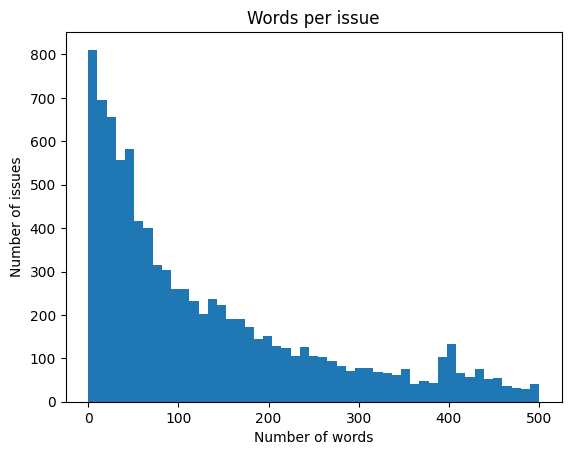

In [30]:
import numpy as np
import matplotlib.pyplot as plt

df_issues["text"].str.split().apply(len).hist(
    bins=np.linspace(0, 500, 50), grid=False
)
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")

The distribution has the long tail characterstic of most text datasets. Most of the texts are fairly short, few texts are over 500 words these might include code, logs, errors etc. Transformer models have a context sixe of 512 tokens or larger, truncating a handful of long issues is not likely to affect the overall performance. Next let's define our training and validation set.

### Creating Training Sets

Creating training and validation sets for multilabel problems is trickier because there is no guranteed balance for all labels. For this we can use [SciKit-multilearn libaray](http://scikit.ml/), which is specifically setup for this purpose. First we've to transform the labels into a format model can process. We can use `MultiLabelBinarizer` class from SciKit-learn. which accepts a list of labels and creates a vector with zeros for absent labels and ones for present labels. Let's test this by fit and tranform on `all_labels` to learn the mapping from label name to ID as follows:

In [31]:
all_labels

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [32]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

To create the splits we can use the `iterative_train_test_split()` function from Scikit-multilearn, which creates train/test splits iteratively to achieve balanced labels. We can wrap it in a function that we can apply to `DataFrame`s. Since this function expects a two-dimenstional feature matrix, we need to add a dimension to the possible indices before making the split:

In [33]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(
        ind,
        labels,
        test_size,
    )
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

With this `balanced_split()` function, we can split the data into supervised and unsupervised datasets, and then create balanced training, validation and test sets for supervised part:

In [34]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

df_clean.head()

,text,labels,split
0,Potential incorrect application of layer norm ...,[],unlabeled
1,Multi-GPU seq2seq example evaluation significa...,[],unlabeled
2,[DeepSpeed] ZeRO stage 3 integration: getting ...,[],unlabeled
3,Can't load model to estimater\n\nI was trying ...,[],unlabeled
4,[LXMERT] Unclear what img_tensorize does with ...,[],unlabeled


In [35]:
np.random.seed(0)
df_train, df_tmp = balanced_split(
    df_sup, test_size=0.5
)
df_valid, df_test = balanced_split(
    df_tmp, test_size=0.5
)

Finally, let's create a `DatasetDict` with all the splits so that we can easily tokenize the dataset and integrate with the `Trainer`.

In [36]:
df_train.head()

,text,labels
26,Add new CANINE model\n\n# 🌟 New model addition...,[new model]
107,Please implement DUMA: Reading Comprehension w...,[new model]
264,Can DeepSpeed ZeRO-3 be applied for training? ...,[new model]
484,XLSR-53\n\n# 🚀 Feature request\r\n\r\nIs it po...,[new model]
566,[examples] should all examples support the pre...,[examples]


All our splits have an index, so we'll reset the index before adding it to DatasetDict.

In [37]:
from datasets import DatasetDict, Dataset

ds = DatasetDict(
{
    "train": Dataset.from_pandas(df=df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True)),
}
)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

This looks good, so the last thing to do is to create some training slices so that we can evaluate the performance of each classifier as a function of the training set size.

### Create Traininig Slices

This dataset has two characterstics that we want to investigate in this notebook: sparse labelled data and multilabel classification. The training sample consists ofonly 223 samples which is really small even for transfer learning. In this notebook we'll slice the training data further to investigate various regime or functions to deal with such situations and compare the performance against the number of training datapoints uses. We'll start with only eight samples per label and build up until the slice covers the full training set using `iterative_train_test_split()` function:

In [38]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]['labels'])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0


for i, k in enumerate(train_samples):
    print(k)
    print(f"Number of training slices: {k}")
    print(f"Previous number of training slices: {last_k}")
    print(f"Length of indices: {len(indices_pool)}")
    print(f"Length of labels: {len(labels)}")
    # indices_pool, labels, new_slice, _ = iterative_train_test_split(
    #     X=indices_pool, # Initially this will be all_indices, then for each iteration a slice(8, 16, etc) will be reduced and go into new_slice
    #     y=labels,
    #     test_size=(k-last_k)/len(labels)
    # )
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    print(f"Number of indices pool after iterative split: {len(indices_pool)}")
    print(f"Number of labels after iterative split: {len(labels)}")
    print(f"Number of samples in new slice after iterative split: {len(new_slice)}")
    last_k = k

    if i == 0:
        train_slices.append(new_slice)
    else:
        train_slices.append(np.concatenate((
            train_slices[-1], # Previous slice
            new_slice, # current slice
        )))

# Add full dataset
train_slices.append(all_indices), train_samples.append(len(ds['train']))

8
Number of training slices: 8
Previous number of training slices: 0
Length of indices: 223
Length of labels: 223
Number of indices pool after iterative split: 213
Number of labels after iterative split: 213
Number of samples in new slice after iterative split: 10
16
Number of training slices: 16
Previous number of training slices: 8
Length of indices: 213
Length of labels: 213
Number of indices pool after iterative split: 204
Number of labels after iterative split: 204
Number of samples in new slice after iterative split: 9
32
Number of training slices: 32
Previous number of training slices: 16
Length of indices: 204
Length of labels: 204
Number of indices pool after iterative split: 187
Number of labels after iterative split: 187
Number of samples in new slice after iterative split: 17
64
Number of training slices: 64
Previous number of training slices: 32
Length of indices: 187
Length of labels: 187
Number of indices pool after iterative split: 155
Number of labels after iterative s

(None, None)

In [39]:
len(train_slices), train_slices[0][:5], train_slices[1][:5]

(6,
 array([[ 0],
        [ 2],
        [ 9],
        [11],
        [18]]),
 array([[ 0],
        [ 2],
        [ 9],
        [11],
        [18]]))

In [40]:
# Let's squeeze the train slices to remove the additional dimenstion added to work with iterative_train_test_split
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [41]:
len(train_slices), train_slices[0][:5], train_slices[1][:5]

(6, array([ 0,  2,  9, 11, 18]), array([ 0,  2,  9, 11, 18]))

In [42]:
print(f"Target split size:\n{train_samples}")
print(f"Actual split sizes:\n{[len(x) for x in train_slices]}")

Target split size:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


## Implementing a Naive Bayseline

Whenever we start a new NLP project, it's always a good idea to establish a strong baseline there are two reasons for this:

1. A baseline based on regular expressions or handcrafted rules might already work well, In this case no need to bring out transformers which is hard to maintain, deploy in production.
2. The baselines provide quick checks and comparison as we explore more complex models. For example, if we achieve 80% accuracy on validation set with BERT we might write it off as a hard dataset. But what if we've a logistic regression baseline with 95% accuracy, we'll then investigate or debug what's wrong with the model.

So let's start out analysis by training a baseline model. For text classification  great baseline is *Naive Bayes classifier* whicc is very simple and quick to train. sci-Kit Learn's Naive Bayes doesn't support multi label classification out of the box. But we can use Scikit-multilearn to cast the problem as one-vs-rest classification task where we train *L* binary classifiers for *L* labels.

First let's use a multilabel binarizer to create a new `label_ids` column in our training sets. We can use `map()` to take of all processing in one go.

In [43]:
ds["train"]["labels"][:10]

[['new model'],
 ['new model'],
 ['new model'],
 ['new model'],
 ['examples'],
 ['examples'],
 ['new model'],
 ['new model'],
 ['examples'],
 ['tensorflow or tf']]

In [44]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [45]:
print(f"Raw labels:\n{ds['train']['labels'][:10]}")
print(f"Labels after transform:\n{ds['train']['label_ids'][:10]}")

Raw labels:
[['new model'], ['new model'], ['new model'], ['new model'], ['examples'], ['examples'], ['new model'], ['new model'], ['examples'], ['tensorflow or tf']]
Labels after transform:
[[0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0]]


To measure the performance of our classifiers, we'll use the micro and macro F1-scores, where the former tracks performance on the frequent labels and the later on all the labels disregarding the frequency. Since we'll be evaluation each model across different-sized training splits, let's create a `defaultdict` witha list to store the scores per split:

In [46]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

Next let's write some code to train and evaluate our baseline across increasing training set sizes:

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:

    # Get traning slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])

    # Use a count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])

    # Create and train out model
    classifier = BinaryRelevance(
        classifier=MultinomialNB(),
    )
    classifier.fit(X_train_counts, y_train)

    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True,
    )
    print(clf_report)
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

{'documentation': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, 'examples': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'model training': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16}, 'new model': {'precision': 1.0, 'recall': 0.7083333333333334, 'f1-score': 0.8292682926829268, 'support': 24}, 'pipeline': {'precision': 0.5, 'recall': 0.18181818181818182, 'f1-score': 0.26666666666666666, 'support': 11}, 'pytorch': {'precision': 0.6, 'recall': 0.3, 'f1-score': 0.4, 'support': 10}, 'tensorflow or tf': {'precision': 0.4, 'recall': 0.18181818181818182, 'f1-score': 0.25000000000000006, 'support': 11}, 'tokenization': {'precision': 0.5, 'recall': 0.2692307692307692, 'f1-score': 0.35000000000000003, 'support': 26}, 'usage': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12}, 'micro avg': {'precision': 0.6326530612244898, 'recall': 0.25203252032520324, 'f1-score': 0.3604651162790698, 'support': 123}, 'macro avg': {'pre

In [48]:
macro_scores, micro_scores

(defaultdict(list,
             {'Naive Bayes': [0.23288166214995487,
               0.21006897585844955,
               0.24086240556828795,
               0.25730500818220114,
               0.28271105113210376,
               0.27403710305671086]}),
 defaultdict(list,
             {'Naive Bayes': [0.3604651162790698,
               0.30208333333333337,
               0.41081081081081083,
               0.4435483870967742,
               0.5046728971962616,
               0.5346534653465347]}))

In [49]:
import matplotlib.pyplot as plt
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()

    plt.tight_layout()
    plt.show()

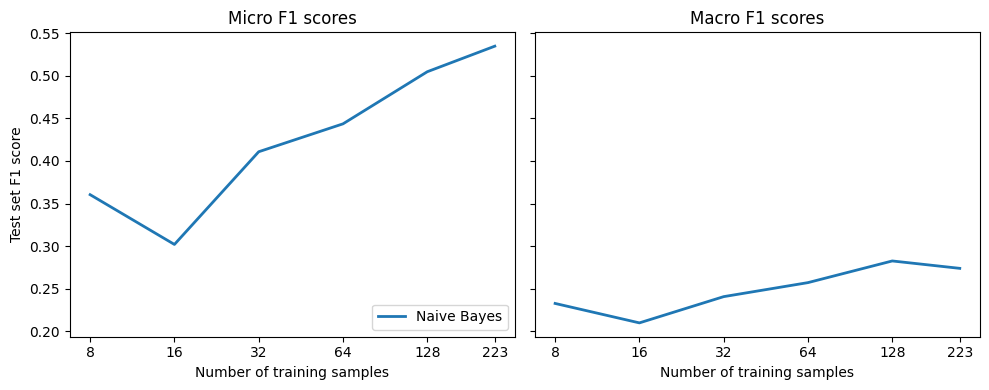

In [50]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

Note that we plot the number of samples on a logarithmic scale. From the figure we can see that the micro and macro F1-scores both improve as we increase the number of training samples. Let's now see how the results fare against transformer-based approaches.

## Working with No Labeled Data

The first technique that we'll consider is the *zero-shot classification*, which is suitable in settings where we've no labelled data or labelling samples is expensive. We'll cheat a bit in this section since we will still use the test data to measure the performance, but we will not use any data to train the model(otherwise the comparison to the following approaches would be difficult).

The goal of zero-shot classification is to make use of a pretrained model without any additional fine-tuning on task specific corpus. How could this work? Let's take BERT, BERT pretrained models are trained on wikipedia dumps to predict a masked token. To predict a masked token, BERT needs to be aware of the topic in the context. We can try to tick the model into classifying a document for us by prodviding a sentence like:

*This section was about the topic [MASK].*

The model should then give a reasonable suggestion for the document's topic, since this is a natural text to occur in the dataset.

Let's illustrate this further with the following toy problem:
Suppose we've a watch party, one group likes romcom and another group likes action. But we've exhausted all the movies the group knows. We wan't to know what type of movie is based on a little movie description. The first thing to try is to load BERT-base in the `fill-mask` pipeline, which uses the masked language to predict the content of masked tokens:

In [51]:
# Load the model
from transformers import pipeline
pipe = pipeline("fill-mask", model="bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
movie_desc = "The main characters of the movie is a retired gangster coming back to save his family."
prompt = "The movie belongs to [MASK] genre."

output = pipe(movie_desc + prompt)
output

[{'score': 0.12692779302597046,
  'token': 2530,
  'token_str': 'western',
  'sequence': 'the main characters of the movie is a retired gangster coming back to save his family. the movie belongs to western genre.'},
 {'score': 0.10347744822502136,
  'token': 20067,
  'token_str': 'gangster',
  'sequence': 'the main characters of the movie is a retired gangster coming back to save his family. the movie belongs to gangster genre.'},
 {'score': 0.09434739500284195,
  'token': 2023,
  'token_str': 'this',
  'sequence': 'the main characters of the movie is a retired gangster coming back to save his family. the movie belongs to this genre.'},
 {'score': 0.0414746068418026,
  'token': 16046,
  'token_str': 'bollywood',
  'sequence': 'the main characters of the movie is a retired gangster coming back to save his family. the movie belongs to bollywood genre.'},
 {'score': 0.036460988223552704,
  'token': 10874,
  'token_str': 'thriller',
  'sequence': 'the main characters of the movie is a reti

In [53]:
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}")

Token western:	0.127
Token gangster:	0.103
Token this:	0.094
Token bollywood:	0.041
Token thriller:	0.036


Cleary the model predicts what genre it belongs. We can also turn this around, and instead of getting the most likely tokens we can query the pipeline for the probabality of a few given tokens. For this task we might choose `action`, and `romcom`, so we can pass them to pipeline as targets:

In [54]:
movie_desc = "In this movie is about how two opposite personalities fall in love with each other."
output = pipe(movie_desc + prompt, targets=["romance", "action"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}")

Token romance:	0.044
Token action:	0.003


As expected, the predicted probabality for `action` is much smaller than `romance`. Let's try this for action as well.

In [55]:
movie_desc = "A non-violent tribe is attacked by warriors looking for slaves and humans to be sacrificed. One of the tribesmen is captured, but he manages to escape in a bid to save his family."
output = pipe(movie_desc + prompt, targets=["romance", "action"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}")

Token romance:	0.022
Token action:	0.005


In [56]:
movie_desc = "A non-violent tribe is attacked by warriors looking for slaves and humans to be sacrificed. One of the tribesmen is captured, but he manages to escape in a bid to save his family."
output = pipe(movie_desc + prompt, targets=["romance", "action"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}")

Token romance:	0.022
Token action:	0.005


The predicted token probabality is bad. But this the key idea of many approaches to be discussed in this notebook: find a way to adapt a pretraine model for another task without training. In this case we set up a prompt with a ask in such a way that we use a masked language model directly for classiication. Let's see if we can do better by adapting a model that has been fine-tuned on a task that's closer to text classification: *natural language inference* (NLI).

Using the masked language model for classification is a nice trick, but we can do better still by using a model that has been trained ona task that is closer to classification. There is a neat proxy task called *text entailment* that fits the bill. In text entailment, the model needs to determine whether two text passages are likely to follow or contradict each other. Models are typically trained tod etect entailments and contradictions with datasets such as Multi-Genre NLI Corpus(MNLI) or Cross-Lingual NLI Corpus (XNLI).

Each sample in these datasets is composed of three parts:

1. Premise
2. Hypothesis
3. Label

Which can be one of:

1. entailment
2. neutral
3. contradiction

The entailment label is assigned when the hypothesis text is necessarily true under the premise. The contradiction label is used when the hypothesis is necessarily false or inappropriate under the premise. If neither of the cases applies neutral label.

*Examples for these three*

![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/9-dealing-with-few-to-no-labels/mnli-three-classes.png?raw=1)

Now we can hijack this model trained on mnli dataset to build a classifier without needing any labels at all! The key idea is to treat the text we wish to classify as the premise, and then formulate the hypothesis as:

"The example is about {label}."

When we insert the class name for the label. The entailment score tells us how likely the premise is aboyt the topic, and we can run this for any number of classes sequenially. Few drawbacks:

1. We've to run a forward pass for all the available classes, which is less efficient than a standard classifier
2. The label names have a great impact on accuracy, as `class 1` label name has no hint to determine whether it's entailment, . The best approach is to use a label with semantic meaning.

Transformers has an MNLI model for zero-shot classification built in. We can intialize the pipeline as follows:

In [57]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification")
pipe

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [58]:
sample = ds["train"][0]
print(f"Labels: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [59]:
output["labels"], output["scores"]

(['new model',
  'tensorflow or tf',
  'examples',
  'usage',
  'pytorch',
  'documentation',
  'model training',
  'tokenization',
  'pipeline'],
 [0.983889102935791,
  0.3655166029930115,
  0.3364446461200714,
  0.29671603441238403,
  0.24781309068202972,
  0.24500343203544617,
  0.2352941781282425,
  0.17372360825538635,
  0.16041657328605652])

> **Note:** Since we are usign subword tokenizer we can pass code to the pipeline. Even though the dataset doesn't have lots of code, code itself is natural langauge so this shouldn't be a problem. We can also get information like framework in use etc.

We can see the model is confident about new model but it also gives high scores for other labels as well. This is because the data passed is not similar to the dataset domain, thut it's a challenging task for the model.

Let's write a function to evaluate a single sequence and use `map()` to apply it to all sequences.

In [60]:
def zero_shot_pipeline(example):
  output = pipe(example["text"], all_labels, multi_label=True)
  # Output has predicted_labels and scores, let's add them
  example["predicted_labels"] = output["labels"]
  example["scores"] = output["scores"]
  return example

False

In [73]:
import os
zero_shot_output_dir = "ds_zero_shot/"
is_data_present = len(os.listdir(zero_shot_output_dir))> 1
if not is_data_present:
  ds_zero_shot = ds["valid"].map(zero_shot_pipeline)
else:
  ds_zero_shot_loaded = Dataset.load_from_disk("ds_zero_shot/")

In [82]:
ds_zero_shot.save_to_disk(zero_shot_output_dir)

In [84]:
ds_zero_shot_loaded = Dataset.load_from_disk("ds_zero_shot/")

In [83]:
!tar -zcf ds_zero_shot.tar.gz ds_zero_shot/

Now that we've scores, the next step is to determine which set of labels should be assigned to each example. We'll use the below options:
1. Define a threshold score and select all labels above threshold
2. Pick the top k labels with the k highest scores

Let's write a funtion to this for us:

In [77]:
def get_preds(example, threshold=None, topk=None):
  preds = []
  if threshold:
    for label, score in zip(example["predicted_labels"], example["scores"]):
      if score >= threshold:
        preds.append(label)
  elif topk:
    for i in range(topk):
      preds.append(example["predicted_labels"][i])
  else:
    raise ValueError("Set either `threshold` or `topk`")
  return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

Next let's write a second function, that returns the Scikit-learn classification report from a dataset with predicted labels:

In [78]:
def get_clf_report(ds):
  y_true = np.array(ds["label_ids"])
  y_pred = np.array(ds["pred_label_ids"])
  return classification_report(
      y_true,
      y_pred,
      zero_division=0,
      target_names=mlb.classes_,
      output_dict=True
  )

Let's combine these two functions, let's start with the top-k method by increasing k for several values and then plotting the micro and macro f1-scores across the validation set:

In [85]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
  ds_zero_shot_k = ds_zero_shot_loaded.map(get_preds, batched=False,
                                    fn_kwargs={'topk': topk})
  clf_report = get_clf_report(ds_zero_shot_k)
  micros.append(clf_report["micro avg"]["f1-score"])
  macros.append(clf_report["macro avg"]["f1-score"])

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

In [86]:
macros, micros

([0.4328047974551859,
  0.41191702300926974,
  0.3736855006983264,
  0.36106103221911373],
 [0.4867256637168142,
  0.4518072289156626,
  0.3972602739726028,
  0.36764705882352944])

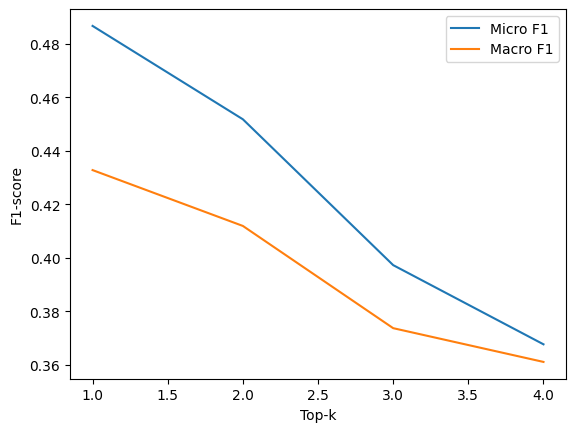

In [87]:
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

From the plot we can see that the best results are obtained by selecting the label with the highest score per example(top 1). As most of our samples have a single label.

Next let's try out the threshold method.

In [91]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot_k = ds_zero_shot.map(
        get_preds,
        fn_kwargs={"threshold": threshold}
      )
    clf_report = get_clf_report(ds_zero_shot_k)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

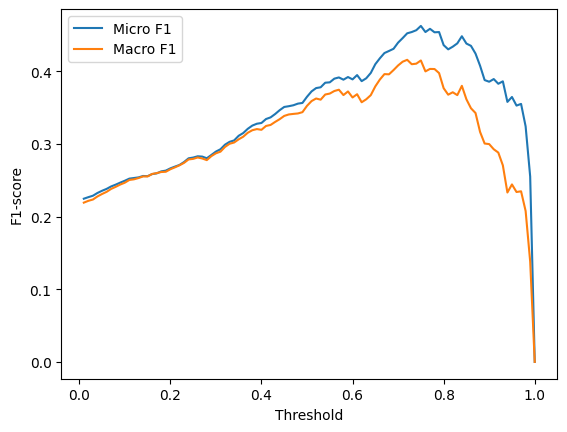

In [92]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [94]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (micro): {best_t} with F1-score {best_macro:.2f}.')

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (micro): 0.72 with F1-score 0.42.
